In [20]:
import os
import copy
import math
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import transformers
from transformers import (BertTokenizer, BertModel,
                          DistilBertTokenizer, DistilBertModel)

In [21]:
train = pd.read_csv("../input/shopee-product-matching/train.csv")
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


MIN words: 1, MAX words: 61


(array([9.9080e+03, 1.6276e+04, 7.1970e+03, 7.2500e+02, 8.1000e+01,
        3.0000e+01, 1.3000e+01, 8.0000e+00, 4.0000e+00, 8.0000e+00]),
 array([ 1.,  7., 13., 19., 25., 31., 37., 43., 49., 55., 61.]),
 <BarContainer object of 10 artists>)

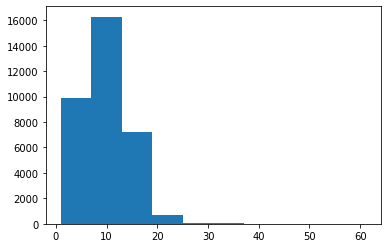

In [22]:
title_lengths = train['title'].apply(lambda x: len(x.split(" "))).to_numpy()
print(f"MIN words: {title_lengths.min()}, MAX words: {title_lengths.max()}")
plt.hist(title_lengths)

In [23]:
class CFG:
    DistilBERT = True # if set to False, BERT model will be used
    bert_hidden_size = 768
    
    batch_size = 64
    epochs = 100
    num_workers = 4
    learning_rate = 1e-5 
    scheduler = "ReduceLROnPlateau"
    step = 'epoch'
    patience = 2
    factor = 0.8
    dropout = 0.5
    model_path = "/kaggle/working"
    max_length = 30
    model_save_name = "bert_model.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [24]:
if CFG.DistilBERT:
    model_name='cahya/distilbert-base-indonesian'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    bert_model = DistilBertModel.from_pretrained(model_name)
else:
    model_name='cahya/bert-base-indonesian-522M'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    bert_model = BertModel.from_pretrained(model_name)

## pre-process

In [25]:
lbl_encoder = LabelEncoder()
train['label_code'] = lbl_encoder.fit_transform(train['label_group'])
NUM_CLASSES = train['label_code'].nunique()
train.head()

,posting_id,image,image_phash,title,label_group,label_code
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,666
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,7572
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,6172
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,10509
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,9425


In [26]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, mode="train", max_length=None):
        self.dataframe = dataframe
        if mode != "test":
            self.targets = dataframe['label_code'].values
        texts = list(dataframe['title'].apply(lambda o: str(o)).values)
        self.encodings = tokenizer(texts, 
                                   padding=True, 
                                   truncation=True, 
                                   max_length=max_length)
        self.mode = mode
        
        
    def __getitem__(self, idx):
        # putting each tensor in front of the corresponding key from the tokenizer
        # HuggingFace tokenizers give you whatever you need to feed to the corresponding model
        item = {key: torch.tensor(values[idx]) for key, values in self.encodings.items()}
        # when testing, there are no targets so we won't do the following
        if self.mode != "test":
            item['labels'] = torch.tensor(self.targets[idx]).long()
        return item
    
    def __len__(self):
        return len(self.dataframe)

In [27]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        
        return output

In [28]:
class Model(nn.Module):
    def __init__(self, 
                 bert_model, 
                 num_classes=NUM_CLASSES, 
                 last_hidden_size=CFG.bert_hidden_size):
        
        super().__init__()
        self.bert_model = bert_model
        self.arc_margin = ArcMarginProduct(last_hidden_size, 
                                           num_classes, 
                                           s=30.0, 
                                           m=0.50, 
                                           easy_margin=False)
    
    def get_bert_features(self, batch):
        output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        last_hidden_state = output.last_hidden_state # shape: (batch_size, seq_length, bert_hidden_dim)
        CLS_token_state = last_hidden_state[:, 0, :] # obtaining CLS token state which is the first token.
        return CLS_token_state
    
    def forward(self, batch):
        CLS_hidden_state = self.get_bert_features(batch)
        output = self.arc_margin(CLS_hidden_state, batch['labels'])
        return output

In [29]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [30]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()
    
    def reset(self):
        self.avg, self.sum, self.count = [0]*3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count
    
    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

In [31]:
def one_epoch(model, 
              criterion, 
              loader,
              optimizer=None, 
              lr_scheduler=None, 
              mode="train", 
              step="batch"):
    
    loss_meter = AvgMeter()
    acc_meter = AvgMeter()
    
    tqdm_object = tqdm(loader, total=len(loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items()}
        preds = model(batch)
        loss = criterion(preds, batch['labels'])
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step == "batch":
                lr_scheduler.step()
                
        count = batch['input_ids'].size(0)
        loss_meter.update(loss.item(), count)
        
        accuracy = get_accuracy(preds.detach(), batch['labels'])
        acc_meter.update(accuracy.item(), count)
        if mode == "train":
            tqdm_object.set_postfix(train_loss=loss_meter.avg, accuracy=acc_meter.avg, lr=get_lr(optimizer))

        else:
            tqdm_object.set_postfix(valid_loss=loss_meter.avg, accuracy=acc_meter.avg)
    
    return loss_meter, acc_meter

In [32]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [33]:
def get_accuracy(preds, targets):
    preds = preds.argmax(dim=1)
    acc = (preds == targets).float().mean()
    return acc

In [34]:
def train_eval(epochs, model, train_loader, valid_loader, 
               criterion, optimizer, lr_scheduler=None):
    
    best_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print("*" * 30)
        print(f"Epoch {epoch + 1}")
        current_lr = get_lr(optimizer)
        
        model.train()
        train_loss, train_acc = one_epoch(model, 
                                          criterion, 
                                          train_loader, 
                                          optimizer=optimizer,
                                          lr_scheduler=lr_scheduler,
                                          mode="train",
                                          step=CFG.step)                     
        train_loss_list.append(train_loss.avg)
        train_acc_list.append(train_acc.avg)
        model.eval()
        with torch.no_grad():
            valid_loss, valid_acc = one_epoch(model, 
                                              criterion, 
                                              valid_loader, 
                                              optimizer=None,
                                              lr_scheduler=None,
                                              mode="valid")
            val_loss_list.append(valid_loss.avg)
            val_acc_list.append(valid_acc.avg)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{CFG.model_path}/{CFG.model_save_name}')
            print("Saved best model!")
        
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(valid_loss.avg)
            if current_lr != get_lr(optimizer):
                print("Loading best model weights!")
                model.load_state_dict(torch.load(f'{CFG.model_path}/{CFG.model_save_name}', 
                                                 map_location=CFG.device))
        
        print("*" * 30)

In [36]:
train_df, valid_df = train_test_split(train, 
                                      test_size=0.33, 
                                      shuffle=True, 
                                      random_state=42, 
                                      stratify=train['label_code'])

train_dataset = TextDataset(train_df, tokenizer, max_length=CFG.max_length)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=True)

valid_dataset = TextDataset(valid_df, tokenizer, max_length=CFG.max_length)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=CFG.batch_size, 
                                           num_workers=CFG.num_workers, 
                                           shuffle=False)

In [37]:
model = Model(bert_model).to(CFG.device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
if CFG.scheduler == "ReduceLROnPlateau":
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                              mode="min", 
                                                              factor=CFG.factor, 
                                                              patience=CFG.patience)

train_eval(CFG.epochs, model, train_loader, valid_loader,
           criterion, optimizer, lr_scheduler=lr_scheduler)

******************************
Epoch 1


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 2


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 3


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 4


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 5


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 6


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 7


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 8


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 9


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 10


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 11


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 12


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 13


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 14


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 15


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 16


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 17


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 18


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 19


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 20


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 21


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 22


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 23


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 24


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 25


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 26


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 27


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 28


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 29


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 30


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 31


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 32


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 33


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 34


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 35


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 36


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 37


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 38


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 39


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 40


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 41


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 42


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 43


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 44


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 45


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 46


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 47


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 48


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 49


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 50


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 51


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 52


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 53


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 54


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 55


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 56


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 57


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 58


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 59


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 60


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 61


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 62


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 63


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 64


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 65


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 66


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 67


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 68


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 69


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************
******************************
Epoch 70


  0%|          | 0/359 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Saved best model!
******************************


In [38]:
train_loss_list = np.array(train_loss_list)
train_acc_list = np.array(train_acc_list)
val_loss_list = np.array(val_loss_list)
val_acc_list = np.array(val_acc_list)

np.save('bert_train_loss_list.npy', train_loss_list)
np.save('bert_train_acc_list.npy', train_acc_list)
np.save('bert_val_loss_list.npy', val_loss_list)
np.save('bert_val_acc_list.npy', val_acc_list)

In [39]:
!mkdir tokenizer
tokenizer.save_pretrained("./tokenizer")
torch.save(model.state_dict(), "final.pt")

Text(0, 0.5, 'training loss')

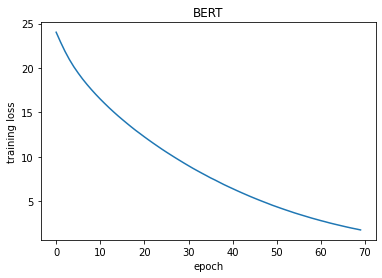

In [46]:
plt.plot(train_loss_list)
plt.title('BERT')
plt.xlabel('epoch')
plt.ylabel('training loss')

Text(0, 0.5, 'training accuracy')

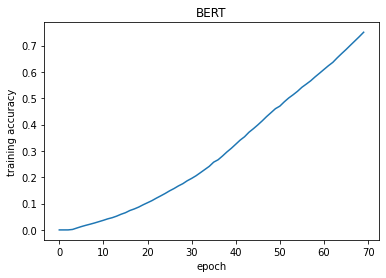

In [47]:
plt.plot(train_acc_list)
plt.title('BERT')
plt.xlabel('epoch')
plt.ylabel('training accuracy')

Text(0, 0.5, 'validation loss')

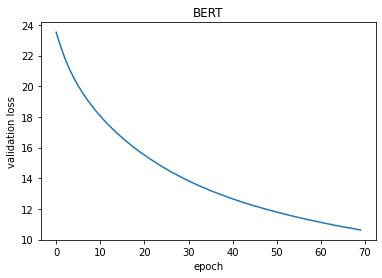

In [48]:
plt.plot(val_loss_list)
plt.title('BERT')
plt.xlabel('epoch')
plt.ylabel('validation loss')

Text(0, 0.5, 'validation accuracy')

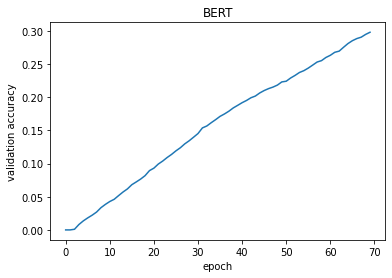

In [49]:
plt.plot(val_acc_list)
plt.title('BERT')
plt.xlabel('epoch')
plt.ylabel('validation accuracy')